(<Figure size 864x576 with 4 Axes>,
 <AxesSubplot:title={'center':'Linear pendulum centered around $(0, 0)$'}, xlabel='$\\theta$', ylabel='$\\omega$'>)

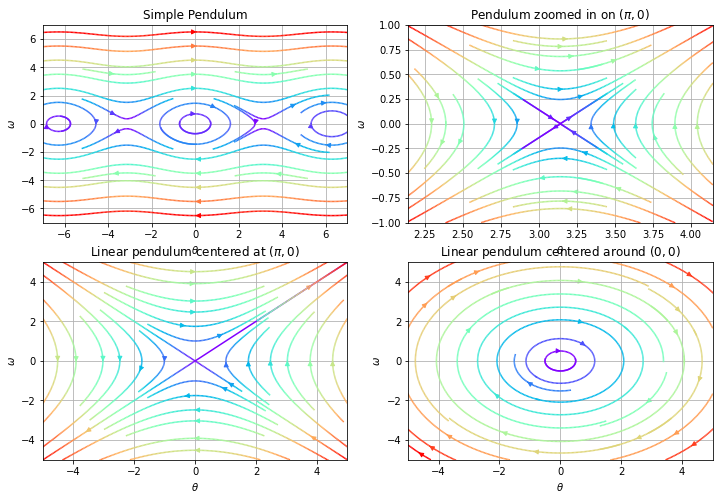

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import phaseportrait

def pendulum(theta, omega):
    dtheta_dt = omega
    domega_dt = -np.sin(theta)

    return dtheta_dt, domega_dt

# Pendulum linearized around (pi, 0)
def linear_pendulum1(theta, omega):
    dtheta_dt = omega
    domega_dt = theta

    return dtheta_dt, domega_dt

# Pendulum linearized around (0, 0)
def linear_pendulum2(theta, omega):
    dtheta_dt = omega
    domega_dt = theta

    return dtheta_dt, -domega_dt

pendulum_fig, axs = plt.subplots(2, 2, figsize = (12, 8))

plt.sca(axs[0, 0])

SimplePendulum = phaseportrait.PhasePortrait2D(
    pendulum, [-7, 7], 
    MeshDim = 15, Density = 1, 
    Title = "Simple Pendulum", 
    xlabel = "$\\theta$", ylabel = "$\\omega$",
    fig = pendulum_fig
)
SimplePendulum.plot()

plt.sca(axs[0, 1])

ZoomedPendulum = phaseportrait.PhasePortrait2D(
    pendulum, [[np.pi - 1, np.pi + 1], [-1, 1]],
    MeshDim = 15, Density = 1,
    Title = "Pendulum zoomed in on $(\\pi, 0)$",
    xlabel = "$\\theta$", ylabel = "$\\omega$",
    fig = pendulum_fig
)
ZoomedPendulum.plot()

plt.sca(axs[1, 0])

LinearPendulum1 = phaseportrait.PhasePortrait2D(
    linear_pendulum1, [-5, 5], 
    MeshDim = 15, Density = 1, 
    Title = "Linear pendulum centered at $(\\pi, 0)$",
    xlabel = "$\\theta$", ylabel = "$\\omega$",
    fig = pendulum_fig
)
LinearPendulum1.plot()

plt.sca(axs[1, 1])

LinearPendulum2 = phaseportrait.PhasePortrait2D(
    linear_pendulum2, [-5, 5], 
    MeshDim = 15, Density = 1, 
    Title = "Linear pendulum centered around $(0, 0)$",
    xlabel = "$\\theta$", ylabel = "$\\omega$",
    fig = pendulum_fig
)
LinearPendulum2.plot()

In [141]:
import numpy as np
import scipy

m = 1
M = 1
g = 9.81
l = 1

a = m * g / M
b = (M + m) * g / (M * l)

A = np.array([
    [0, 1, 0, 0],
    [0, 0, m*g / M, 0],
    [0, 0, 0, 1],
    [0, 0, (M + m)*g/ M * l, 0]
])

B = np.array([
    0,
    1 / M,
    0,
    -1 / (M * l)
])

print(f"Rank of B is {np.linalg.matrix_rank(B)}")

qs = np.zeros(4, dtype = object)
qs[3] = B
qs[2] = A @ B
qs[1] = (A @ A) @ B - b * B
qs[0] = (A @ A @ A) @ B - b * (A @ B)

# Convert from column major to row major.
Tinv = np.transpose(np.array([qs[0], qs[1], qs[2], qs[3]]))
T = np.linalg.inv(Tinv)

Acanon = T @ A @ Tinv
Bcanon = T @ B

print(Acanon)
print(Bcanon)

# s^4 + 10s^3 + 35s^2 + 50s + 24
fs = np.zeros(4, dtype = float)
fs[3] = -Acanon[3, 3] - 10
fs[2] = -Acanon[3, 2] - 35
fs[1] = -Acanon[3, 1] - 50
fs[0] = -Acanon[3, 0] - 24
# fs[3] = -Acanon[3, 3] - 1
# fs[2] = -Acanon[3, 2] - 0.35
# fs[1] = -Acanon[3, 1] - 0.05
# fs[0] = -Acanon[3, 0] - 0.0024

Fcanon = np.array([fs[0], fs[1], fs[2], fs[3]])
F = Fcanon @ T

Acontrolled = Acanon + np.outer(Bcanon, Fcanon)
print(Acontrolled)
print(np.linalg.eigvals(Acontrolled))


Rank of B is 1
[[ 0.    1.    0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]
 [ 0.    0.   19.62  0.  ]]
[0. 0. 0. 1.]
[[  0.   1.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]
 [-24. -50. -35. -10.]]
[-4. -3. -2. -1.]


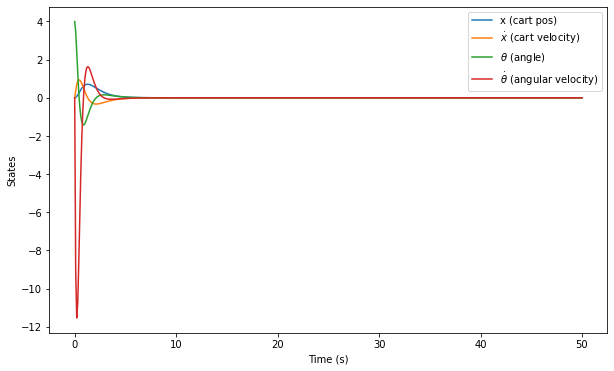

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

x0 = np.array([0.0, 0.0, 4, 0.0])
def dynamics(t, x):
    return Acontrolled @ x

t_span = (0, 50)
t_eval = np.linspace(*t_span, 500)
sol = solve_ivp(dynamics, t_span, x0, t_eval = t_eval)

plt.figure(figsize = (10, 6))
plt.plot(sol.t, sol.y.T)
plt.xlabel("Time (s)")
plt.ylabel("States")
plt.legend(["x (cart pos)", "$\\dot{x}$ (cart velocity)", "$\\theta$ (angle)", "$\\dot{\\theta}}$ (angular velocity)"])
plt.show()

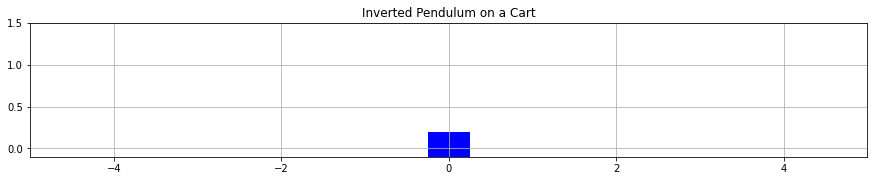

In [162]:
import matplotlib.animation as animation

cart_width = 0.5
cart_height = 0.4

fig, ax = plt.subplots(figsize = (15, 10))
ax.set_aspect("equal")
ax.grid()
ax.set_xlim(-5, 5)
ax.set_ylim(-0.1, l + cart_height + 0.1)

plt.title("Inverted Pendulum on a Cart")

line, = ax.plot([], [], 'k-', lw = 2)
cart = plt.Rectangle((0, 0), cart_width, cart_height, fc = "blue")

ax.add_patch(cart)

def init_state():
    line.set_data([], [])
    cart.set_xy((-cart_width / 2, -cart_height / 2))

    return line, cart

def update_state(i):
    cart_x, cart_vel, theta, dtheta = sol.y[:, i]

    pendulum_x = cart_x + l * np.sin(theta)
    pendulum_y = -l * np.cos(theta)

    line.set_data([cart_x, pendulum_x], [cart_height / 2, pendulum_y])
    cart.set_xy((cart_x - cart_width / 2, -cart_height / 2))

    return line, cart

anim = animation.FuncAnimation(
    fig, update_state, frames= len(t_span), init_func = init_state,
    interval = 1000 * (t_span[1] - t_span[0]), blit = True
)


plt.show()